In [1]:
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
sns.set()

DATA_DIR = '../../data/'
MODEL_DIR = os.path.join(DATA_DIR, 'model')
GRAPH_DIR = os.path.join(DATA_DIR, 'graphs')

In [3]:
os.makedirs(GRAPH_DIR, exist_ok=True)

## **Analyse graphique de l'accuracy et de la loss sur les deux modèles**

### **Chargement des données**

On charge les informations de la phase d'apprentissage précédement enregistré en format pickle.

In [4]:
with open(os.path.join(MODEL_DIR, 'all_model_no_euroSAT_info.pkl'), 'rb') as handle:
    all_model_no_eurosat_info = pickle.load(handle)

In [5]:
with open(os.path.join(MODEL_DIR, 'all_model_euroSAT_info.pkl'), 'rb') as handle:
    all_model_eurosat_info = pickle.load(handle)

### **Création du graphique**

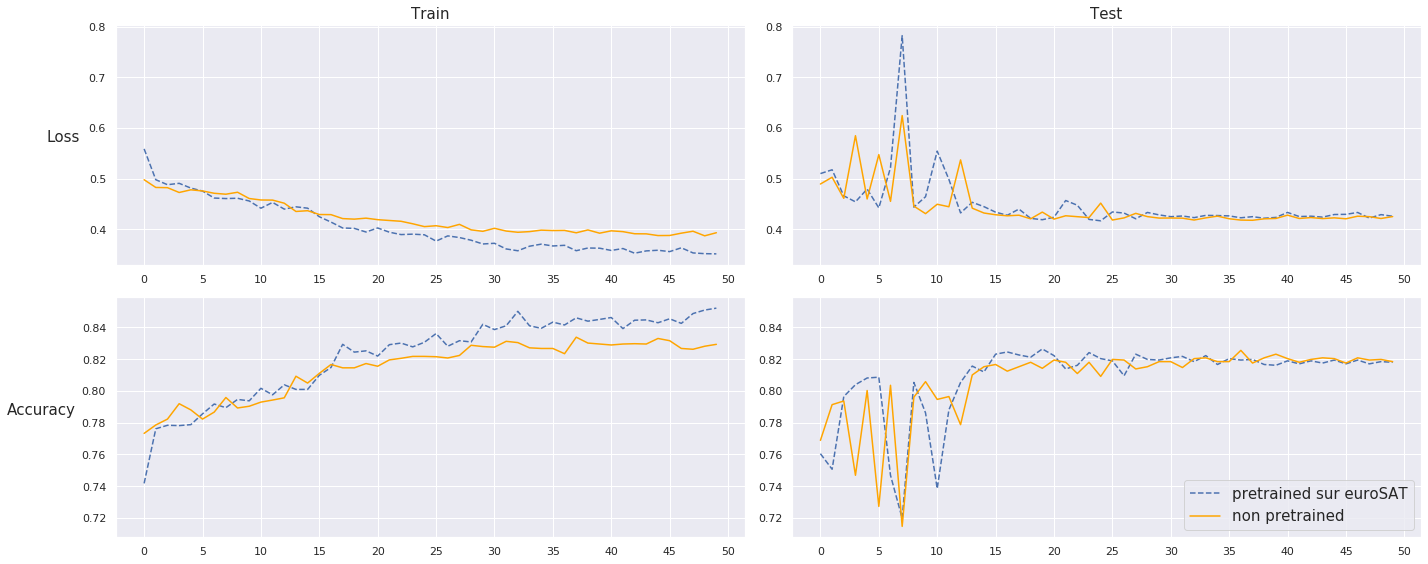

In [6]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(221)
ax1.plot([float(i)  for i in all_model_eurosat_info['train']['loss']], 'b--', label='pretrained sur euroSAT')
ax1.plot([float(i)  for i in all_model_no_eurosat_info['train']['loss']], 'orange', label='non pretrained')
ax1.set_xticks(np.arange(0,51,5))

ax2 = plt.subplot(222, sharey = ax1)
ax2.plot([float(i)  for i in all_model_eurosat_info['test']['loss']], 'b--', label='pretrained sur euroSAT')
ax2.plot([float(i)  for i in all_model_no_eurosat_info['test']['loss']], 'orange', label='non pretrained')
ax2.set_xticks(np.arange(0,51,5))

ax3 = plt.subplot(223)
ax3.plot([float(i)  for i in all_model_eurosat_info['train']['accuracy']], 'b--', label='pretrained sur euroSAT')
ax3.plot([float(i)  for i in all_model_no_eurosat_info['train']['accuracy']], 'orange', label='non pretrained')
ax3.set_xticks(np.arange(0,51,5))

ax4 = plt.subplot(224, sharey = ax3)
ax4.plot([float(i)  for i in all_model_eurosat_info['test']['accuracy']], 'b--', label='pretrained sur euroSAT')
ax4.plot([float(i)  for i in all_model_no_eurosat_info['test']['accuracy']], 'orange', label='non pretrained')
ax4.legend(loc='lower right', fontsize=15)
ax4.set_xticks(np.arange(0,51,5))

ax1.set_title('Train', fontsize=15)
ax2.set_title('Test', fontsize=15)
ax1.set_ylabel('Loss', rotation=0, labelpad=25, fontsize=15)
ax3.set_ylabel('Accuracy', rotation=0, labelpad=40, fontsize=15)

plt.tight_layout()

plt.savefig(os.path.join(GRAPH_DIR, 'model_training.jpg'), optimize=True, quality=95)
plt.show()

## **Courbes ROC / matrice de confusion sur l'échantillon test**

Pour évaluer la performance du modèle nous utilisons une matrice de confusion et une courbe ROC.

In [7]:
import os
import time
import copy

import tensorflow as tf
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('%d GPU(s) disponible.' % torch.cuda.device_count())
    print('GPU utilisé :', torch.cuda.get_device_name(0))

else:
    print('Pas de GPU disponible, utilisation du CPU.')
    device = torch.device("cpu")

1 GPU(s) disponible.
GPU utilisé : GeForce GTX 1050 Ti


### **Mise en place des modèles**

In [9]:
data_transforms = {
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../../data/images/all'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['test']}
class_names = image_datasets['test'].classes

In [10]:
model_euroSAT = models.resnet50(pretrained=False, progress=True)
num_ftrs = model_euroSAT.fc.in_features
model_euroSAT.fc = nn.Linear(num_ftrs, 2)
model_euroSAT.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'all_model_euroSAT.pt')))

model_no_euroSAT = models.resnet50(pretrained=False, progress=True)
num_ftrs = model_no_euroSAT.fc.in_features
model_no_euroSAT.fc = nn.Linear(num_ftrs, 2)
model_no_euroSAT.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'all_model_no_euroSAT.pt')))

criterion = nn.CrossEntropyLoss()

### **Evaluation des modèles**

- Prédictions du modèle non pretrained

In [11]:
model_no_euroSAT = model_no_euroSAT.to(device)

In [12]:
since = time.time()

score_liste_no_euroSAT = []
pred_liste_no_euroSAT = []

model_no_euroSAT.eval()

for inputs, labels in dataloaders['test']:
    
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model_no_euroSAT(inputs)
        logit, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
    
    score_liste_no_euroSAT.append(outputs.detach().cpu().numpy())
    pred_liste_no_euroSAT.append((preds.detach().cpu().numpy(), labels.data.detach().cpu().numpy()))
    
time_elapsed = time.time() - since
print("Temps d'exécution : {}".format(time_elapsed))

Temps d'exécution : 113.06180572509766


- Prédictions du modèle pretrained sur euroSAT

In [13]:
model_euroSAT = model_euroSAT.to(device)

In [14]:
since = time.time()

score_liste_euroSAT = []
pred_liste_euroSAT = []

model_euroSAT.eval()

for inputs, labels in dataloaders['test']:
    
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model_euroSAT(inputs)
        logit, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
    
    score_liste_euroSAT.append(outputs.detach().cpu().numpy())
    pred_liste_euroSAT.append((preds.detach().cpu().numpy(), labels.data.detach().cpu().numpy()))
    
time_elapsed = time.time() - since
print("Temps d'exécution : {}".format(time_elapsed))

Temps d'exécution : 113.62886381149292


Nous créons un dictionnaire `score` qui contiendra les scores du label `1` (*détruit*) des deux modèles.

In [15]:
scores = {'model_euroSAT': [], 'model_no_euroSAT': []}

for vec in score_liste_no_euroSAT:
    for value in vec:
        scores['model_no_euroSAT'].append(value[1])

for vec in score_liste_euroSAT:
    for value in vec:
        scores['model_euroSAT'].append(value[1])

La même opération est effectuée sur les prédictions des modèles et leurs labels associés.

In [16]:
preds = {'model_euroSAT': [], 'model_no_euroSAT': []}

for i in range(len(pred_liste_euroSAT)):
    for j in range(pred_liste_euroSAT[i][0].shape[0]):
        preds['model_euroSAT'].append(pred_liste_euroSAT[i][0][j])

for i in range(len(pred_liste_no_euroSAT)):
    for j in range(pred_liste_no_euroSAT[i][0].shape[0]):
        preds['model_no_euroSAT'].append(pred_liste_no_euroSAT[i][0][j])

In [17]:
labels = {'model_euroSAT': [], 'model_no_euroSAT': []}

for i in range(len(pred_liste_euroSAT)):
    for j in range(pred_liste_euroSAT[i][1].shape[0]):
        labels['model_euroSAT'].append(pred_liste_euroSAT[i][1][j])

for i in range(len(pred_liste_no_euroSAT)):
    for j in range(pred_liste_no_euroSAT[i][1].shape[0]):
        labels['model_no_euroSAT'].append(pred_liste_no_euroSAT[i][1][j])

Vérification des opérations.

In [18]:
print(len(scores['model_euroSAT']),
      len(preds['model_euroSAT']),
      len(labels['model_euroSAT']))

print(len(scores['model_no_euroSAT']),
      len(preds['model_no_euroSAT']),
      len(labels['model_no_euroSAT']))

2164 2164 2164
2164 2164 2164


In [19]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve

In [20]:
print ("Classification report :")

print(classification_report(labels['model_no_euroSAT'],
                            preds['model_no_euroSAT']))

print ("Accuracy : ",accuracy_score(labels['model_no_euroSAT'],
                                    preds['model_no_euroSAT']))

cm_no_euroSAT = confusion_matrix(labels['model_no_euroSAT'],
                                 preds['model_no_euroSAT'])

ROC_no_euroSAT = roc_auc_score(labels['model_no_euroSAT'],
                               preds['model_no_euroSAT'])

print ("AUC : ", ROC_no_euroSAT)

Classification report :
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1346
           1       0.81      0.71      0.75       818

    accuracy                           0.83      2164
   macro avg       0.82      0.80      0.81      2164
weighted avg       0.82      0.83      0.82      2164

Accuracy :  0.8257855822550831
AUC :  0.8021694271172031


In [21]:
print ("Classification report :")

print(classification_report(labels['model_euroSAT'],
                            preds['model_euroSAT']))

print ("Accuracy : ", accuracy_score(labels['model_euroSAT'],
                                           preds['model_euroSAT']))

cm_euroSAT = confusion_matrix(labels['model_euroSAT'],
                              preds['model_euroSAT'])

ROC_euroSAT = roc_auc_score(labels['model_euroSAT'],
                            preds['model_euroSAT']) 

print ("AUC : ", ROC_euroSAT)

Classification report :
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1346
           1       0.81      0.70      0.75       818

    accuracy                           0.83      2164
   macro avg       0.82      0.80      0.81      2164
weighted avg       0.83      0.83      0.82      2164

Accuracy :  0.8262476894639557
AUC :  0.802301122223958


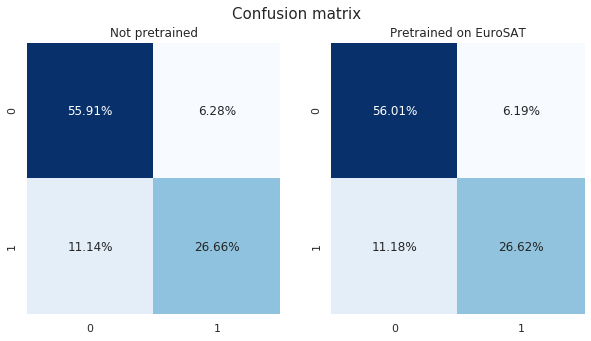

In [22]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

sns.heatmap(cm_no_euroSAT / np.sum(cm_no_euroSAT), annot=True, 
            fmt='.2%', cmap='Blues', cbar=False, ax=ax1).set_title('Not pretrained')
sns.heatmap(cm_euroSAT / np.sum(cm_euroSAT), annot=True, 
            fmt='.2%', cmap='Blues', cbar=False, ax=ax2).set_title('Pretrained on EuroSAT')

fig.suptitle('Confusion matrix', fontsize=15)
fig.subplots_adjust(wspace=0.2)

plt.savefig(os.path.join(GRAPH_DIR, 'confusion_matrix.jpg'), optimize=True, quality=95)
plt.show()

In [23]:
fpr_no_euroSAT, tpr_no_euroSAT, thresholds = roc_curve(labels['model_no_euroSAT'],
                                                       scores['model_no_euroSAT'])

fpr_euroSAT, tpr_euroSAT, thresholds = roc_curve(labels['model_euroSAT'],
                                                 scores['model_euroSAT'])

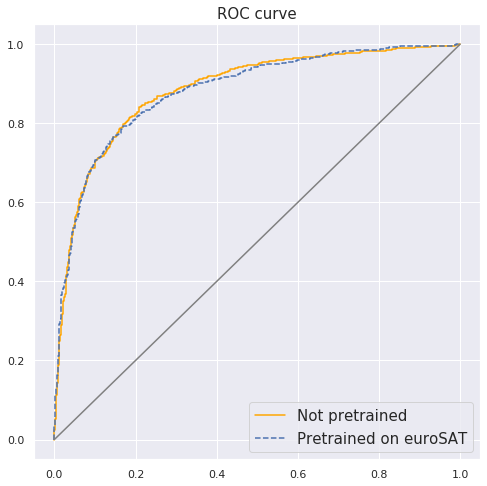

In [24]:
plt.figure(figsize=(8, 8))

plt.plot(fpr_no_euroSAT, tpr_no_euroSAT, 'orange', label='Not pretrained', linewidth=1.5)
plt.plot(fpr_euroSAT, tpr_euroSAT, 'b--', label='Pretrained on euroSAT', linewidth=1.5)
plt.plot([0,1], [0,1], color='grey')

plt.title("ROC curve", fontsize=15)
plt.legend(loc='lower right', fontsize=15)

plt.savefig(os.path.join(GRAPH_DIR, 'roc_curve.jpg'), optimize=True, quality=95)
plt.show()